In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")
from sklearn.metrics import roc_auc_score, auc

from helpers.synthesis import *
from helpers.visualization import *


dpi = 800

In [9]:
# fixed 
results_dir = "/global/ml4hep/spss/rrmastandrea/synth_SM_AD/NF_results_wide_seed_2/"

n_sig_inj = [0]

n_seed = 2
num_bkg = 320000
num_sig = 20000

rerun = True

# Load in


In [10]:
process = "None" #StandardScale
keys = [ "salad", "cathode", "curtains", "feta", "random"]


n_avg = 1 # number of classifiers to average the scores over
n_trials_post_avg = int(n_seed / n_avg)

# truth labels
y_test = np.concatenate((torch.zeros((num_bkg, 1)), torch.ones((num_sig,1))))

#x_axis = np.logspace(-8, 0, 400)
x_axis = np.linspace(1e-5, 1, 100)

# initialize dictionaries
auc_dict = {k:{n:[] for n in n_sig_inj} for k in keys}

Working on n_sig = 0...
dict_keys(['salad', 'cathode', 'curtains', 'feta', 'random'])


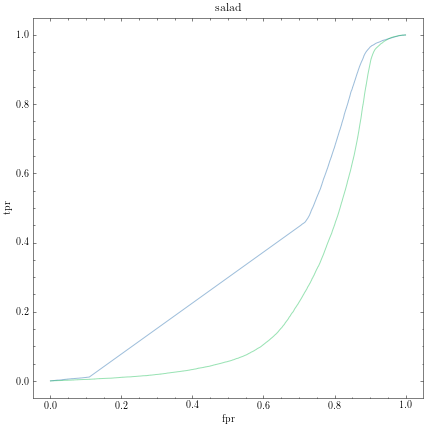

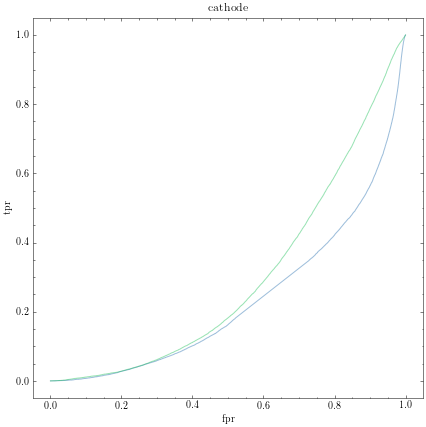

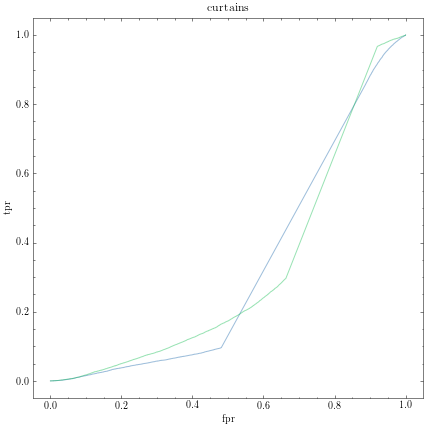

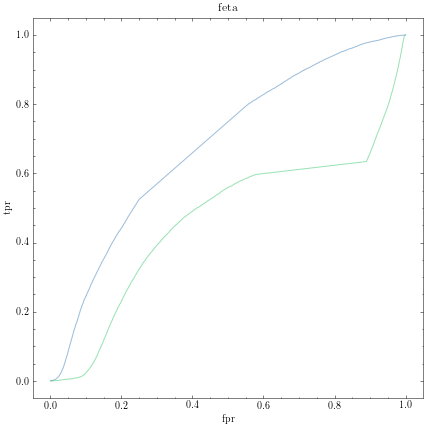

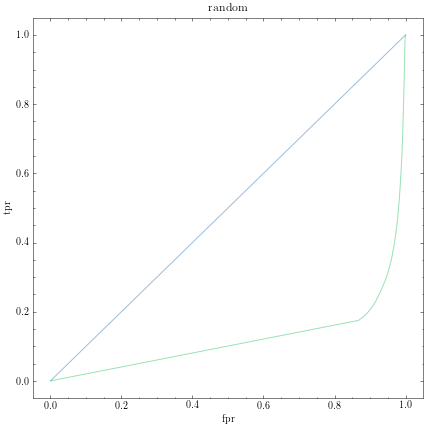

In [12]:
if rerun:
    for n in n_sig_inj:

        print(f"Working on n_sig = {n}...")

        # load in the scores data for a given signal injection
        all_results_bkg, all_results_sig = load_in_data(n, num_bkg, process,
                                                    keys, n_seed, 2, results_dir)
        print(all_results_bkg.keys())
        for k in keys:
            
            plt.figure()
            plt.title(k)
            plt.xlabel("fpr")
            plt.ylabel("tpr")
            
            for seed in range(n_seed):
      
                scores = np.concatenate((all_results_bkg[k][seed], all_results_sig[k][seed]))
                fpr, tpr, _ = roc_curve(y_test, scores)
                plt.plot(fpr, tpr, alpha = 0.4) 
                loc_auc = auc(fpr, tpr)
                if loc_auc < 0.5:
                    loc_auc = 1.0 - loc_auc
                auc_dict[k][n].append(loc_auc)   
                
            plt.show()




# Take the median / get errorbands

In [13]:
# initialize dictionaries
med_aucs_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}

for n in n_sig_inj:
    
    for k in keys:
        
        med_aucs_dict[k][0] = np.append(med_aucs_dict[k][0], np.median(auc_dict[k][n]))
        med_aucs_dict[k][1] = np.append(med_aucs_dict[k][1], np.percentile(auc_dict[k][n], 16))
        med_aucs_dict[k][2] = np.append(med_aucs_dict[k][2], np.percentile(auc_dict[k][n], 84))
                        

In [14]:
print(med_aucs_dict)

{'salad': [array([0.69970832]), array([0.62809541]), array([0.77132122])], 'cathode': [array([0.73392943]), array([0.70278455]), array([0.76507431])], 'curtains': [array([0.68241373]), array([0.6789017]), array([0.68592575])], 'feta': [array([0.60713166]), array([0.53376299]), array([0.68050033])], 'random': [array([0.69001064]), array([0.50000469]), array([0.8800166])]}


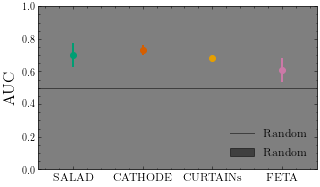

In [15]:
colors_dict = {"full_sup":"grey",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00",
                "combined": "#e41a1c",
               "combined_scores": "#0072B2",
                "ideal_ad":"#56B4E9"}

labels_dict = {"full_sup":"Fully Supervised",
               "salad": "SALAD",
               "feta": "FETA",
               "cathode":"CATHODE",
               "curtains":"CURTAINs",
                "combined": "Combined (Events)",
               "combined_scores": "Combined (Scores)",
              "ideal_ad": "Ideal. AD"}

l = 3
f_1 = 20
f_2 = 30
alpha = 0.4


fig = plt.figure(figsize = (5,3))

medianauc=np.array([0.651,0.721,0.674,0.592])
lowerauc=np.array([0.553,0.589,0.608,0.520])
upperauc=np.array([0.799,0.791,0.749,0.665])


for i, k in enumerate(keys[:-1]):
    plt.errorbar(i, med_aucs_dict[k][0], 
                 [med_aucs_dict[k][0]-med_aucs_dict[k][1], med_aucs_dict[k][2]-med_aucs_dict[k][0]],
                  marker="o", ls="none", elinewidth=2, markersize = 6, color = colors_dict[k])
    
plt.axhline(0.5 ,color="k", label = "Random", alpha = 0.5)
plt.fill_between([-0.5, 3.5], [0, 0], [1, 1] ,color="k", label = "Random", alpha = 0.5)
    
plt.xticks([0,1,2,3], ["SALAD","CATHODE","CURTAINs","FETA"], fontsize = 12)
plt.ylabel("AUC", fontsize = 16)
plt.ylim(0,1)

plt.xlim(-.5, 3.5)
dpi = 800 
plt.savefig(f'plots/aucs.pdf', facecolor='white', dpi = dpi)
plt.legend(loc = "lower right", fontsize = 12)
plt.show()